In [4]:
import urllib.request

def make_data_object_name(dataset_name, year, month, day, hour, realization, forecast_period):
    template_string = "prods_op_{}_{:02d}{:02d}{:02d}_{:02d}_{:02d}_{:03d}.nc"
    return template_string.format(dataset_name, year, month, day, hour, realization, forecast_period)

def download_data_object(dataset_name, data_object_name, parent):
    url = "https://s3.eu-west-2.amazonaws.com/" + dataset_name + "/" + data_object_name
    urllib.request.urlretrieve(url, parent + '/' + data_object_name) # save in this directory with same name

In [5]:
import os
import boto3
from botocore.client import Config

def boto_download(prefix, download_dir='./'):
    session = boto3.session.Session(aws_access_key_id=os.environ['ACCESS_KEY'], # These need to be set at environmental
                                    aws_secret_access_key=os.environ['SECRET_KEY']) # variables as per your AWS credentials
    s3 = session.resource('s3', config=Config(signature_version='s3v4'))
    bucket = s3.Bucket('mogreps-uk')
    keys = bucket.objects.filter(Prefix=prefix)
    for key in keys:
        key_name = key.key
        fpath = '{}{}'.format(download_dir, key_name)
        if os.path.isfile(fpath):
            print('{} already exists, skipping...'.format(fpath))
        else:
            print('Downloading {}...'.format(key_name))
            with open(fpath, 'wb') as outf:
                bucket.download_fileobj(Key=key_name, Fileobj=outf)

In [7]:
files = []

for month in [8]:
    for day in [1, 4, 7, 15, 18, 21]:
        for hour in [3, 9, 15, 21]:
            fcsts = [3] if hour == 21 else [3, 6]
            for fcst in fcsts:
                f = 'prods_op_mogreps-uk_2016{:02d}{:02d}_{:02d}_00_{:03d}'.format(month, day, hour, fcst)
                boto_download(f, '../netcdf/')
                files.append(f+'.nc')

../netcdf/prods_op_mogreps-uk_20160801_03_00_003.nc already exists, skipping...
../netcdf/prods_op_mogreps-uk_20160801_03_00_006.nc already exists, skipping...
../netcdf/prods_op_mogreps-uk_20160801_09_00_003.nc already exists, skipping...
../netcdf/prods_op_mogreps-uk_20160801_09_00_006.nc already exists, skipping...
../netcdf/prods_op_mogreps-uk_20160801_15_00_003.nc already exists, skipping...
../netcdf/prods_op_mogreps-uk_20160801_15_00_006.nc already exists, skipping...
../netcdf/prods_op_mogreps-uk_20160801_21_00_003.nc already exists, skipping...
../netcdf/prods_op_mogreps-uk_20160804_03_00_003.nc already exists, skipping...
../netcdf/prods_op_mogreps-uk_20160804_03_00_006.nc already exists, skipping...
../netcdf/prods_op_mogreps-uk_20160804_09_00_003.nc already exists, skipping...
../netcdf/prods_op_mogreps-uk_20160804_09_00_006.nc already exists, skipping...
../netcdf/prods_op_mogreps-uk_20160804_15_00_003.nc already exists, skipping...
../netcdf/prods_op_mogreps-uk_20160804_1

In [8]:
import iris
from iris import quickplot as qplt
import numpy as np
import cartopy.crs as ccrs
import os
from matplotlib import pyplot as plt

iris.FUTURE.netcdf_promote = True
iris.FUTURE.netcdf_no_unlimited = True
%matplotlib inline

# for f in files:
#     os.rename('../data/'+f, '../data/'+'tmpfile')
#     cl = iris.load('../data/'+'tmpfile')
#     subset = cl.extract(iris.Constraint(grid_latitude=lambda cell: 2 < cell < 3))
#     iris.save(subset, '../data/'+f)
#     os.remove('../data/'+'tmpfile')

In [9]:
cl = iris.load('../netcdf/'+files[0])

/home/ubuntu/miniconda3/lib/python3.6/site-packages/iris/coords.py:826: UserWarning: Coordinate 'grid_longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/home/ubuntu/miniconda3/lib/python3.6/site-packages/iris/coords.py:826: UserWarning: Coordinate 'grid_latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


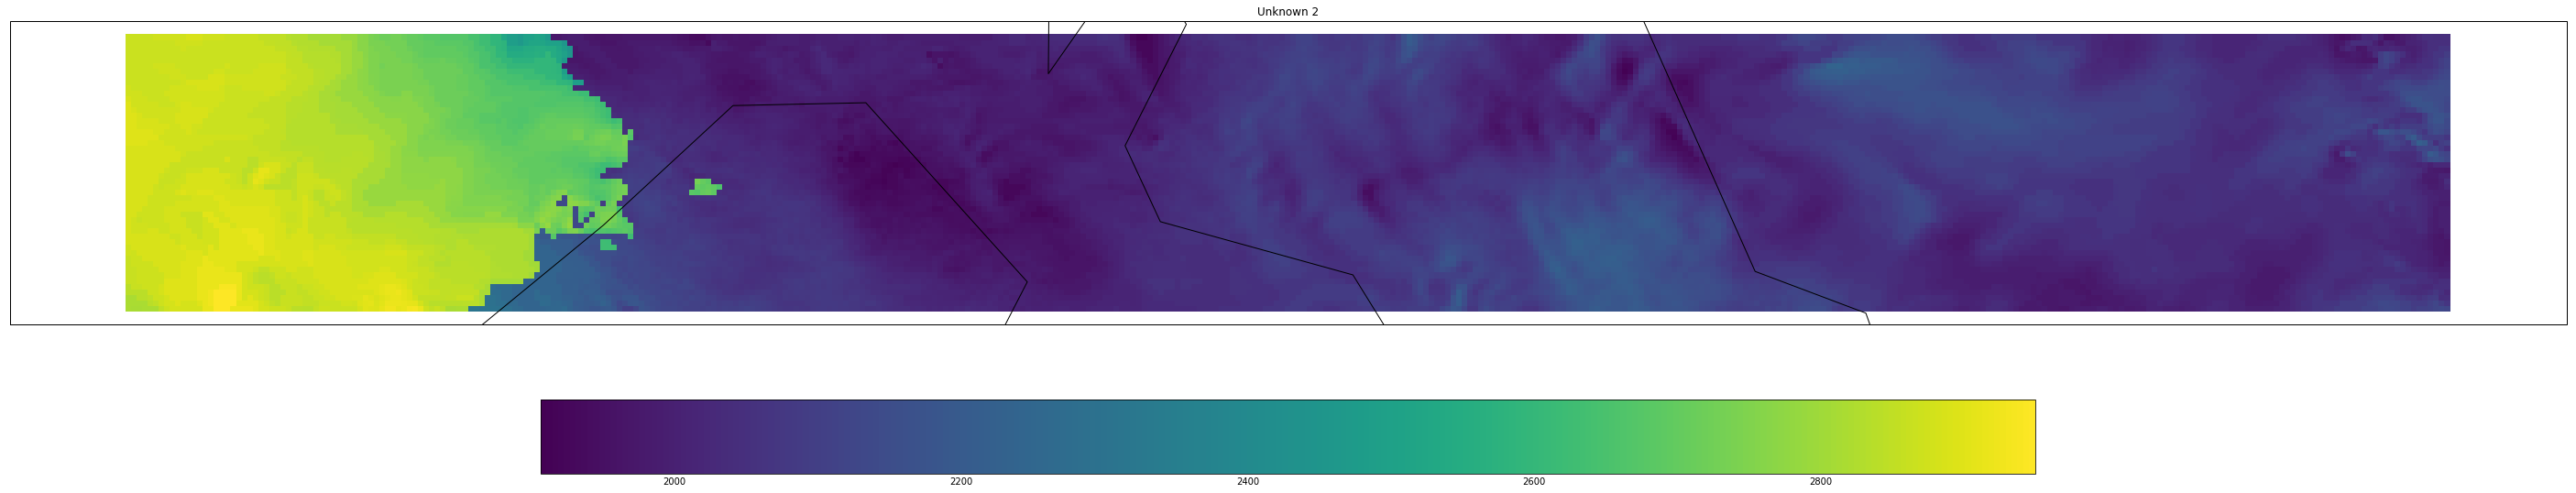

In [10]:
plt.figure(figsize=(50,10))
cube = cl[2][0]
qplt.pcolormesh(cube)
plt.gca().coastlines()

In [31]:
cl.extract('surface_altitude')[0].coord_dims('grid_latitude')[0]

0

In [30]:
cl.extract('surface_altitude')[0].ndim

2

In [17]:
iris.save(cl.extract('surface_altitude')[0], '../netcdf/surface_altitude.nc')

In [8]:
%time [c.extract(iris.Constraint(grid_latitude = lambda x: 2.65 < x < 2.67)) for c in cl]

CPU times: user 236 ms, sys: 4 ms, total: 240 ms
Wall time: 232 ms


[<iris 'Cube' of unknown / (1) (time: 4; grid_longitude: 421)>,
 <iris 'Cube' of unknown_2 / (1) (time: 4; grid_longitude: 421)>,
 <iris 'Cube' of unknown_0 / (1) (-- : 4; grid_longitude: 421)>,
 <iris 'Cube' of unknown_1 / (1) (time: 4; grid_longitude: 421)>,
 <iris 'Cube' of cloud_base_altitude_assuming_only_consider_cloud_area_fraction_greater_than_2p5_oktas / (kft) (time: 4; grid_longitude: 421)>,
 <iris 'Cube' of wet_bulb_freezing_level_altitude / (m) (time: 4; grid_longitude: 421)>,
 <iris 'Cube' of stratiform_snowfall_rate / (kg m-2 s-1) (time: 37; grid_longitude: 421)>,
 <iris 'Cube' of cloud_area_fraction_assuming_maximum_random_overlap / (1) (time: 4; grid_longitude: 421)>,
 <iris 'Cube' of wet_bulb_potential_temperature / (K) (time: 4; pressure: 3; grid_longitude: 421)>,
 <iris 'Cube' of air_pressure_at_sea_level / (Pa) (time: 4; grid_longitude: 421)>,
 <iris 'Cube' of air_temperature / (K) (time: 4; grid_longitude: 421)>,
 <iris 'Cube' of air_temperature / (K) (time: 4; pre

In [9]:
%time cl.extract(iris.Constraint(grid_latitude = lambda x: 2.65 < x < 2.67))

CPU times: user 224 ms, sys: 12 ms, total: 236 ms
Wall time: 230 ms


[<iris 'Cube' of unknown / (1) (time: 4; grid_longitude: 421)>,
<iris 'Cube' of unknown_2 / (1) (time: 4; grid_longitude: 421)>,
<iris 'Cube' of unknown_0 / (1) (-- : 4; grid_longitude: 421)>,
<iris 'Cube' of unknown_1 / (1) (time: 4; grid_longitude: 421)>,
<iris 'Cube' of cloud_base_altitude_assuming_only_consider_cloud_area_fraction_greater_than_2p5_oktas / (kft) (time: 4; grid_longitude: 421)>,
<iris 'Cube' of wet_bulb_freezing_level_altitude / (m) (time: 4; grid_longitude: 421)>,
<iris 'Cube' of stratiform_snowfall_rate / (kg m-2 s-1) (time: 37; grid_longitude: 421)>,
<iris 'Cube' of cloud_area_fraction_assuming_maximum_random_overlap / (1) (time: 4; grid_longitude: 421)>,
<iris 'Cube' of wet_bulb_potential_temperature / (K) (time: 4; pressure: 3; grid_longitude: 421)>,
<iris 'Cube' of air_pressure_at_sea_level / (Pa) (time: 4; grid_longitude: 421)>,
<iris 'Cube' of air_temperature / (K) (time: 4; grid_longitude: 421)>,
<iris 'Cube' of air_temperature / (K) (time: 4; pressure: 2; g

In [10]:
cl[0].coord_system()

RotatedGeogCS(37.5, 177.5, ellipsoid=GeogCS(6371229.0))

In [11]:
iris.coord_systems.RotatedGeogCS(37.5, 177.5, ellipsoid=iris.coord_systems.GeogCS(6371229.0)).as_cartopy_crs()

In [12]:
c = cl[0]

In [13]:
c.regrid?

In [36]:
pts = ccrs.PlateCarree().transform_points(c.coord_system().as_cartopy_crs(),
                                          np.repeat(c.coord('grid_longitude').points,50),
                                          np.repeat(c.coord('grid_latitude').points,421))[:,:2]

In [43]:
pts

array([[-11.21555658,  54.19279913],
       [-11.21555658,  54.19279913],
       [-11.21555658,  54.19279913],
       ..., 
       [  3.32138936,  55.34658386],
       [  3.32138936,  55.34658386],
       [  3.32138936,  55.34658386]])

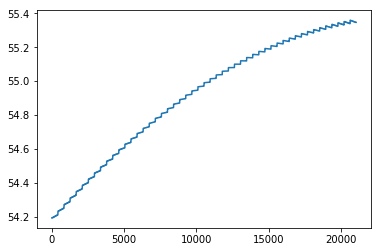

In [44]:
plt.plot(pts[:,1])

In [42]:
len(np.unique(pts[:,1]))

470

In [41]:
pts.reshape((50,421,2))

array([[[-11.21555658,  54.19279913],
        [-11.21555658,  54.19279913],
        [-11.21555658,  54.19279913],
        ..., 
        [-10.94410165,  54.21173691],
        [-10.94410165,  54.21173691],
        [-10.94410165,  54.21173691]],

       [[-10.94809031,  54.23160047],
        [-10.94809031,  54.23160047],
        [-10.94809031,  54.23160047],
        ..., 
        [-10.67626764,  54.24995169],
        [-10.67626764,  54.24995169],
        [-10.67626764,  54.24995169]],

       [[-10.68013429,  54.26982374],
        [-10.68013429,  54.26982374],
        [-10.68013429,  54.26982374],
        ..., 
        [-10.37393072,  54.2897641 ],
        [-10.37393072,  54.2897641 ],
        [-10.37393072,  54.2897641 ]],

       ..., 
       [[  2.44045029,  55.34389393],
        [  2.44045029,  55.34389393],
        [  2.44045029,  55.34389393],
        ..., 
        [  2.75572141,  55.33120475],
        [  2.75572141,  55.33120475],
        [  2.75572141,  55.33120475]],

       [[  